# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [9]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# ACCESS-NRI intake catalogue
import intake

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [10]:
%%time

catalog = intake.cat.access_nri

# access to fs38 NCI project where the ACCESS-ESM-1.5 runs are stored
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

# reduce to only ocean variables
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'], frequency=["mon"], source_id=["ACCESS-ESM1-5"], experiment_id=["historical"], version=["v.*"])


CPU times: user 10.7 s, sys: 743 ms, total: 11.4 s
Wall time: 11.4 s


In [11]:
%%time

cat_df = cmip6_fs38_ocean_datastore.df
cat_df.head()


CPU times: user 117 μs, sys: 0 ns, total: 117 μs
Wall time: 121 μs


,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
0,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/talk/gn/v20200922/talk_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_195001-195912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,talk,gn,v20200922,195001-195912
1,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/volcello/gn/v20200922/volcello_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_195001-195912.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,volcello,gn,v20200922,195001-195912
2,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r29i1p1f1/Omon/po4/gn/v20200922/po4_Omon_ACCESS-ESM1-5_historical_r29i1p1f1_gn_196001-196912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r29i1p1f1,po4,gn,v20200922,196001-196912
3,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r30i1p1f1/Omon/vmo/gn/v20200922/vmo_Omon_ACCESS-ESM1-5_historical_r30i1p1f1_gn_193001-193912.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r30i1p1f1,vmo,gn,v20200922,193001-193912
4,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r30i1p1f1/Omon/arag/gn/v20200922/arag_Omon_ACCESS-ESM1-5_historical_r30i1p1f1_gn_191001-191912.nc,l,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r30i1p1f1,arag,gn,v20200922,191001-191912


## Filter for the variables we want

In [12]:
%%time

sst_df = cat_df[(cat_df['variable_id'] == "tos")]
sst_df


CPU times: user 1.06 ms, sys: 175 μs, total: 1.24 ms
Wall time: 1.22 ms


,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
160,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r39i1p1f1,tos,gn,v20210525,185001-201412
505,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r15i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r15i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r15i1p1f1,tos,gn,v20200803,185001-201412
667,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r13i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r13i1p1f1,tos,gn,v20200803,185001-201412
670,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r27i1p1f1/Omon/tos/gn/v20200922/tos_Omon_ACCESS-ESM1-5_historical_r27i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r27i1p1f1,tos,gn,v20200922,185001-201412
1083,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r11i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r11i1p1f1,tos,gn,v20200803,185001-201412
1202,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r40i1p1f1,tos,gn,v20210525,185001-201412
1378,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r8i1p1f1/Omon/tos/gn/v20200529/tos_Omon_ACCESS-ESM1-5_historical_r8i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r8i1p1f1,tos,gn,v20200529,185001-201412
1750,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r12i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r12i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r12i1p1f1,tos,gn,v20200803,185001-201412
1812,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r34i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r34i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r34i1p1f1,tos,gn,v20210525,185001-201412
1865,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r33i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r33i1p1f1_gn_185001-201412.nc,l,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,historical,r33i1p1f1,tos,gn,v20210525,185001-201412


## get the paths to the data

In [13]:
sst_paths = sst_df['path']
sst_members = sst_df['member_id']


## Load the data

In [14]:
%%time

sst_ensemble = {}
for i,path in enumerate(sst_paths):
    print(i, path)
    sst_ensemble[sst_members.iloc[i]] = xr.open_dataset(str(path))['tos']

sst_ensemble = xr.Dataset(sst_ensemble)
sst_ensemble


0 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc
1 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r15i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r15i1p1f1_gn_185001-201412.nc
2 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r13i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r13i1p1f1_gn_185001-201412.nc
3 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r27i1p1f1/Omon/tos/gn/v20200922/tos_Omon_ACCESS-ESM1-5_historical_r27i1p1f1_gn_185001-201412.nc
4 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r11i1p1f1/Omon/tos/gn/v20200803/tos_Omon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412.nc
5 /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/tos/gn/v20210525/tos_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc
6 /g

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables: (12/40)
    r39i1p1f1  (time, j, i) float32 855MB ...
    r15i1p1f1  (time, j, i) float32 855MB ...
    r13i1p1f1  (time, j, i) float32 855MB ...
    r27i1p1f1  (time, j, i) float32 855MB ...
    r11i1p1f1  (time, j, i) float32 855MB ...
    r40i1p1f1  (time, j, i) float32 855MB ...
    ...         ...
    r30i1p1f1  (time, j, i) float32 855MB ...
    r38i1p1f1  (time, j, i) float32 855MB ...
    r18i1p1f1  (time, j, i) float32 855MB ...
    r20i1p1f1  (time, j, i) float32 855MB ...
    r25i1p1f1  (time, j, i) float32 855MB ...
    r24i1p1f1  (time, j, i) float32 855MB ...

## quick look

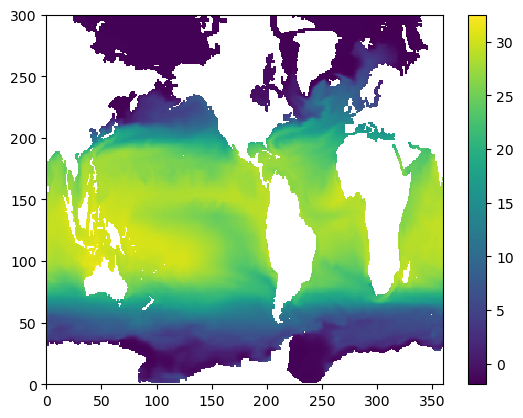

In [15]:
plt.figure()
plt.pcolormesh(sst_ensemble['r1i1p1f1'].isel(time=0))
plt.colorbar()

## Monthly anomalies and climatology

In [ ]:
%%time

# Step 1: Calculate the climatology (mean for each month over all years)
sst_climatology = sst_ensemble.groupby("time.month").mean("time")

# Step 2: Compute the anomaly by subtracting the climatology from the original data
sst_anomalies = sst_ensemble.groupby("time.month") - sst_climatology
sst_anomalies


## Calculate the Oceanic Nino Index (ONI) for ENSO variability

In [17]:
sst_anomalies

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
    month      (time) int64 16kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables: (12/40)
    r39i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r15i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r13i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r27i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r11i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r40i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    ...         ...
    r30i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r38i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r18i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r20i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r25i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan
    r24i1p1f1  (time, j, i) float32 855MB nan nan nan nan ... nan nan nan nan

34.21616232 GB


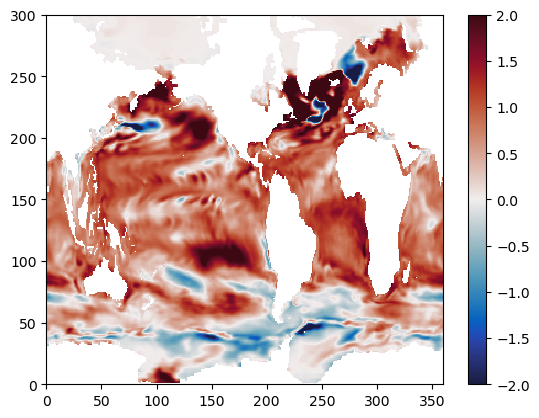

In [18]:
plt.figure()
plt.pcolormesh(sst_anomalies['r1i1p1f1'].isel(time=-1), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

print(sst_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## roll the longitude coordinate

In [6]:
chla = chl.roll(longitude=720, roll_coords=True)
print(chla.coords['longitude'])

lons = chla.coords['longitude'].values
lons[lons<0.0] += 360.0

chla = chla.assign_coords({"longitude":lons})


<xarray.DataArray 'longitude' (longitude: 1440)> Size: 12kB
array([ 0.125,  0.375,  0.625, ..., -0.625, -0.375, -0.125])
Coordinates:
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... -0.375 -0.125


## detrend the data

In [21]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

# Apply the function to each variable in the anomalies dataset
sst_detrended_anomalies = {}

for var in sst_anomalies.data_vars:
    print(f"Processing: {var}")  # Print the current variable name
    
    sst_detrended_anomalies[var] = xr.apply_ufunc(
        detrend_1d,
        sst_anomalies[var],  # Apply to each variable
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[sst_anomalies[var].dtype]
    )

# Convert dictionary back to an xarray Dataset
sst_detrended_anomalies = xr.Dataset(sst_detrended_anomalies)

# Check the detrended dataset
print(sst_detrended_anomalies)


Processing: r39i1p1f1
Processing: r15i1p1f1
Processing: r13i1p1f1
Processing: r27i1p1f1
Processing: r11i1p1f1
Processing: r40i1p1f1
Processing: r8i1p1f1
Processing: r12i1p1f1
Processing: r34i1p1f1
Processing: r33i1p1f1
Processing: r31i1p1f1
Processing: r37i1p1f1
Processing: r6i1p1f1
Processing: r14i1p1f1
Processing: r4i1p1f1
Processing: r23i1p1f1
Processing: r17i1p1f1
Processing: r21i1p1f1
Processing: r29i1p1f1
Processing: r10i1p1f1
Processing: r22i1p1f1
Processing: r36i1p1f1
Processing: r7i1p1f1
Processing: r28i1p1f1
Processing: r1i1p1f1
Processing: r16i1p1f1
Processing: r26i1p1f1
Processing: r2i1p1f1
Processing: r32i1p1f1
Processing: r9i1p1f1
Processing: r35i1p1f1
Processing: r5i1p1f1
Processing: r19i1p1f1
Processing: r3i1p1f1
Processing: r30i1p1f1
Processing: r38i1p1f1
Processing: r18i1p1f1
Processing: r20i1p1f1
Processing: r25i1p1f1
Processing: r24i1p1f1
<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 18

34.21616232 GB


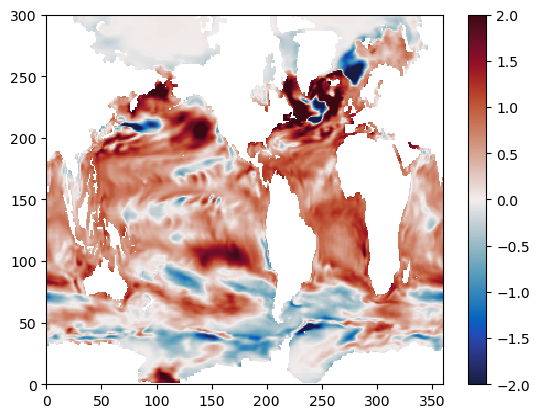

In [22]:
plt.figure()
plt.pcolormesh(sst_detrended_anomalies['r1i1p1f1'].isel(time=-1), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

print(sst_detrended_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## Calculate the ONI

In [31]:
%%time

# Define the Niño 3.4 region bounds
lat_bounds = [-5, 5]  # 5°S to 5°N
lon_bounds = [190, 240]  # 170°W to 120°W

# Create a dictionary to store ONI results for each variable
oni_results = {}

# Iterate through each variable in the dataset
for var in sst_detrended_anomalies.data_vars:
    print(f"Processing ONI for: {var}")

    # Select the Niño 3.4 region
    nino34 = sst_detrended_anomalies[var].where(
        (sst_detrended_anomalies.latitude >= lat_bounds[0]) & (sst_detrended_anomalies.latitude <= lat_bounds[1]) &
        (sst_detrended_anomalies.longitude >= lon_bounds[0]) & (sst_detrended_anomalies.longitude <= lon_bounds[1]),
        drop=True
    )

    # Compute the spatial mean over the Niño 3.4 region
    nino34_anom = nino34.mean(dim=["j", "i"])

    # Apply a 3-month running mean to smooth the anomalies
    oni = nino34_anom.rolling(time=3, center=True).mean()

    # Store ONI results in the dictionary
    oni_results[var] = oni

print("ONI calculation completed for all variables.")

# Convert ONI results to an xarray dataset
oni_ds = xr.Dataset(oni_results)
oni_ds


Processing ONI for: r39i1p1f1
Processing ONI for: r15i1p1f1
Processing ONI for: r13i1p1f1
Processing ONI for: r27i1p1f1
Processing ONI for: r11i1p1f1
Processing ONI for: r40i1p1f1
Processing ONI for: r8i1p1f1
Processing ONI for: r12i1p1f1
Processing ONI for: r34i1p1f1
Processing ONI for: r33i1p1f1
Processing ONI for: r31i1p1f1
Processing ONI for: r37i1p1f1
Processing ONI for: r6i1p1f1
Processing ONI for: r14i1p1f1
Processing ONI for: r4i1p1f1
Processing ONI for: r23i1p1f1
Processing ONI for: r17i1p1f1
Processing ONI for: r21i1p1f1
Processing ONI for: r29i1p1f1
Processing ONI for: r10i1p1f1
Processing ONI for: r22i1p1f1
Processing ONI for: r36i1p1f1
Processing ONI for: r7i1p1f1
Processing ONI for: r28i1p1f1
Processing ONI for: r1i1p1f1
Processing ONI for: r16i1p1f1
Processing ONI for: r26i1p1f1
Processing ONI for: r2i1p1f1
Processing ONI for: r32i1p1f1
Processing ONI for: r9i1p1f1
Processing ONI for: r35i1p1f1
Processing ONI for: r5i1p1f1
Processing ONI for: r19i1p1f1
Processing ONI for

<xarray.Dataset> Size: 348kB
Dimensions:    (time: 1980)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    month      (time) int64 16kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables: (12/40)
    r39i1p1f1  (time) float32 8kB nan 0.05955 0.2544 ... -0.06998 -0.1475 nan
    r15i1p1f1  (time) float32 8kB nan 0.6625 0.5712 ... -0.3424 -0.3611 nan
    r13i1p1f1  (time) float32 8kB nan 0.6679 0.7406 ... -0.06323 -0.1859 nan
    r27i1p1f1  (time) float32 8kB nan 0.541 0.8043 0.868 ... 0.6335 0.7787 nan
    r11i1p1f1  (time) float32 8kB nan 0.6689 0.1695 -0.3152 ... -1.096 -1.17 nan
    r40i1p1f1  (time) float32 8kB nan -0.7406 -0.3094 ... 1.986 2.256 nan
    ...         ...
    r30i1p1f1  (time) float32 8kB nan -1.085 -0.7423 ... 0.07306 -0.0121 nan
    r38i1p1f1  (time) float32 8kB nan 0.4574 0.2063 ... 0.7355 0.9319 nan
    r18i1p1f1  (time) float32 8kB nan 0.7181 1.141 1.409 ... 0.3636 0.574 nan
    r20i1p1f1  (time) float32 8kB nan 1.09 1.296 1.235 ... 0.9405 0.9197 nan
    r25i1p1f1  (time) float32 8kB nan 0.2919 0.2024 ... -0.5902 -0.8785 nan
    r24i1p1f1  (time) float32 8kB nan 0.3446 0.4711 0.5272 ... 0.5931 0.8828 nan

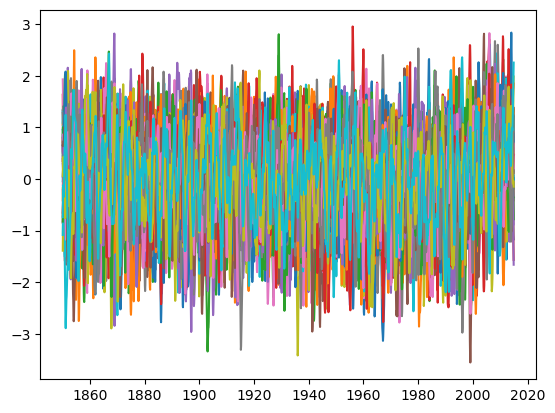

In [34]:
plt.figure()
for ii in np.arange(1,41,1):
    plt.plot(oni_ds.coords['time'], oni_ds['r%ii1p1f1'%(ii)])


In [36]:
oni_ds.to_netcdf("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_ONI.nc")

## Calculate the TPI

In [38]:
# Define the three IPO regions
regions = {
    "Region1": {"lat": [25, 45], "lon": [140, 215]},  # 140°E–145°W (North Pacific)
    "Region2": {"lat": [-10, 10], "lon": [170, 270]},  # 170°E–90°W (Equatorial Pacific)
    "Region3": {"lat": [-50, -15], "lon": [150, 200]}  # 150°E–160°W (South Pacific)
}

# Create a dictionary to store TPI results for each variable
tpi_results = {}

# Iterate through each variable in the dataset
for var in sst_detrended_anomalies.data_vars:
    print(f"Processing TPI for: {var}")

    # Select and compute spatial mean for each region
    region_means = {}
    for region_name, bounds in regions.items():
        selected_region = sst_detrended_anomalies[var].where(
            (sst_detrended_anomalies.latitude >= bounds["lat"][0]) &
            (sst_detrended_anomalies.latitude <= bounds["lat"][1]) &
            (sst_detrended_anomalies.longitude >= bounds["lon"][0]) &
            (sst_detrended_anomalies.longitude <= bounds["lon"][1]),
            drop=True
        )
        region_means[region_name] = selected_region.mean(dim=["j", "i"])

    # Compute the Tripole Index (TPI)
    tpi = region_means["Region2"] - 0.5 * (region_means["Region1"] + region_means["Region3"])

    # Apply a 3-month running mean to smooth the anomalies
    tpi_smoothed = tpi.rolling(time=25, center=True).mean()

    # Store the TPI results
    tpi_results[var] = tpi_smoothed

print("TPI calculation completed for all variables.")

# Convert TPI results to an xarray dataset
tpi_ds = xr.Dataset(tpi_results)
tpi_ds


Processing TPI for: r39i1p1f1
Processing TPI for: r15i1p1f1
Processing TPI for: r13i1p1f1
Processing TPI for: r27i1p1f1
Processing TPI for: r11i1p1f1
Processing TPI for: r40i1p1f1
Processing TPI for: r8i1p1f1
Processing TPI for: r12i1p1f1
Processing TPI for: r34i1p1f1
Processing TPI for: r33i1p1f1
Processing TPI for: r31i1p1f1
Processing TPI for: r37i1p1f1
Processing TPI for: r6i1p1f1
Processing TPI for: r14i1p1f1
Processing TPI for: r4i1p1f1
Processing TPI for: r23i1p1f1
Processing TPI for: r17i1p1f1
Processing TPI for: r21i1p1f1
Processing TPI for: r29i1p1f1
Processing TPI for: r10i1p1f1
Processing TPI for: r22i1p1f1
Processing TPI for: r36i1p1f1
Processing TPI for: r7i1p1f1
Processing TPI for: r28i1p1f1
Processing TPI for: r1i1p1f1
Processing TPI for: r16i1p1f1
Processing TPI for: r26i1p1f1
Processing TPI for: r2i1p1f1
Processing TPI for: r32i1p1f1
Processing TPI for: r9i1p1f1
Processing TPI for: r35i1p1f1
Processing TPI for: r5i1p1f1
Processing TPI for: r19i1p1f1
Processing TPI for

<xarray.Dataset> Size: 348kB
Dimensions:    (time: 1980)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    month      (time) int64 16kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables: (12/40)
    r39i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r15i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r13i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r27i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r11i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r40i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    ...         ...
    r30i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r38i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r18i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r20i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r25i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan
    r24i1p1f1  (time) float32 8kB nan nan nan nan nan ... nan nan nan nan nan

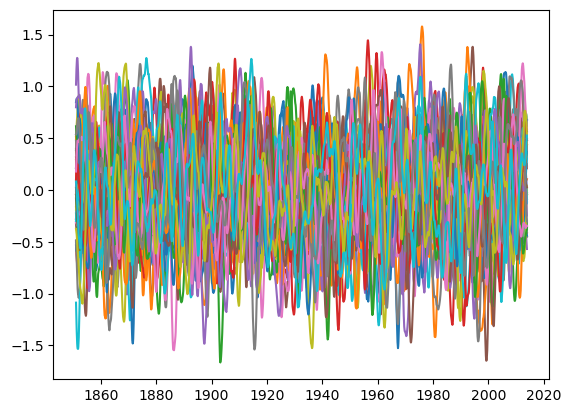

In [39]:
plt.figure()
for ii in np.arange(1,41,1):
    plt.plot(tpi_ds.coords['time'], tpi_ds['r%ii1p1f1'%(ii)])


In [40]:
tpi_ds.to_netcdf("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_TPI.nc")

## Calculate the signal frequency of both the ONI and TPI for each member

In [67]:
%%time

from scipy.signal import hilbert

def retrieve_signal_frequency(ts):
    # drop NaNs
    ts1 = ts.dropna(dim='time')
    # get the min and max year
    years = ts1.time.dt.year + (ts1.time.dt.dayofyear - 1) / 365.25
    # calculate the signal frequency
    analytic_signal = hilbert(ts1)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    freq = np.mean(np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years)))
    return freq

# Create a dictionary to store TPI results for each variable
enso_freq = {}
ipo_freq = {}

# Iterate through each variable in the dataset
for var in oni_ds.data_vars:
    print(f"Processing ENSO frequency for: {var}")
    # solve for frequency of signal
    freq = retrieve_signal_frequency(oni_ds[var])
    # Store the TPI results
    enso_freq[var] = freq
    print("ENSO period = %.2f years"%(1/freq))

# Iterate through each variable in the dataset
for var in tpi_ds.data_vars:
    print(f"Processing IPO frequency for: {var}")
    # solve for frequency of signal
    freq = retrieve_signal_frequency(tpi_ds[var])
    # Store the TPI results
    ipo_freq[var] = freq
    print("IPO period = %.2f years"%(1/freq))



Processing ENSO frequency for: r39i1p1f1
ENSO period = 2.83 years
Processing ENSO frequency for: r15i1p1f1
ENSO period = 2.89 years
Processing ENSO frequency for: r13i1p1f1
ENSO period = 2.89 years
Processing ENSO frequency for: r27i1p1f1
ENSO period = 3.50 years
Processing ENSO frequency for: r11i1p1f1
ENSO period = 2.86 years
Processing ENSO frequency for: r40i1p1f1
ENSO period = 2.94 years
Processing ENSO frequency for: r8i1p1f1
ENSO period = 2.80 years
Processing ENSO frequency for: r12i1p1f1
ENSO period = 2.89 years
Processing ENSO frequency for: r34i1p1f1
ENSO period = 2.89 years
Processing ENSO frequency for: r33i1p1f1
ENSO period = 2.99 years
Processing ENSO frequency for: r31i1p1f1
ENSO period = 3.23 years
Processing ENSO frequency for: r37i1p1f1
ENSO period = 2.66 years
Processing ENSO frequency for: r6i1p1f1
ENSO period = 3.04 years
Processing ENSO frequency for: r14i1p1f1
ENSO period = 2.89 years
Processing ENSO frequency for: r4i1p1f1
ENSO period = 3.25 years
Processing EN

## collapse the dictionaries into one list for plotting

/jobfs/137119010.gadi-pbs/ipykernel_343280/3613004396.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([1/enso_values, 1/ipo_values], labels=["ENSO", "IPO"])


(0.0, 10.0)

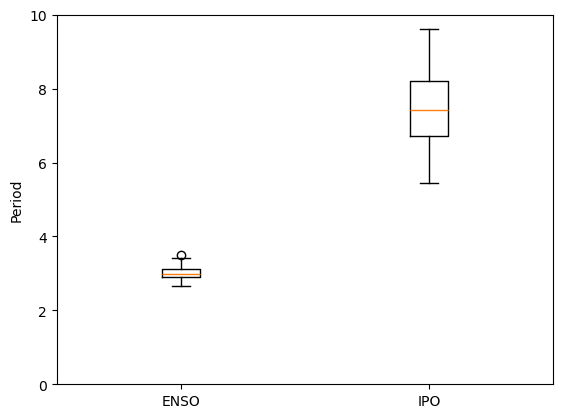

In [89]:
enso_values = np.array(list(enso_freq.values()))
ipo_values = np.array(list(ipo_freq.values()))

plt.figure()
plt.boxplot([1/enso_values, 1/ipo_values], labels=["ENSO", "IPO"])
plt.ylabel("Period")
plt.ylim(0,10)

In [91]:
sst_members.values

array(['r39i1p1f1', 'r15i1p1f1', 'r13i1p1f1', 'r27i1p1f1', 'r11i1p1f1',
       'r40i1p1f1', 'r8i1p1f1', 'r12i1p1f1', 'r34i1p1f1', 'r33i1p1f1',
       'r31i1p1f1', 'r37i1p1f1', 'r6i1p1f1', 'r14i1p1f1', 'r4i1p1f1',
       'r23i1p1f1', 'r17i1p1f1', 'r21i1p1f1', 'r29i1p1f1', 'r10i1p1f1',
       'r22i1p1f1', 'r36i1p1f1', 'r7i1p1f1', 'r28i1p1f1', 'r1i1p1f1',
       'r16i1p1f1', 'r26i1p1f1', 'r2i1p1f1', 'r32i1p1f1', 'r9i1p1f1',
       'r35i1p1f1', 'r5i1p1f1', 'r19i1p1f1', 'r3i1p1f1', 'r30i1p1f1',
       'r38i1p1f1', 'r18i1p1f1', 'r20i1p1f1', 'r25i1p1f1', 'r24i1p1f1'],
      dtype=object)

In [93]:
df = pd.DataFrame({
    "member": sst_members.values,
    "ENSO_period": 1/enso_values,
    "IPO_period": 1/ipo_values
})

df.to_csv("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_enso_ipo_periods.csv", index=False)
df

,member,ENSO_period,IPO_period
0,r39i1p1f1,2.828305,6.292238
1,r15i1p1f1,2.893468,6.549947
2,r13i1p1f1,2.894085,8.212928
3,r27i1p1f1,3.500322,9.623794
4,r11i1p1f1,2.856295,7.458532
5,r40i1p1f1,2.943913,6.811660
6,r8i1p1f1,2.796527,6.790082
7,r12i1p1f1,2.887499,8.195671
8,r34i1p1f1,2.891876,7.430966
9,r33i1p1f1,2.991824,7.109889
